In [1]:
#!/usr/bin/python
#
# This code will prospectively run forecasts based on an existing model

# library calls
#import sys
import os
import os.path
import time
#from os import path
#import json
#import csv
import pandas as pd
import numpy as np

import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import MaxAbsScaler
from sklearn import metrics
from tqdm import trange

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Layer
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#from models import Dense, Dropout, LSTM, Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.layers import LSTM
from keras.models import Sequential

import time

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline


import matplotlib.dates as mdates
import datetime as dt

#from realSim import simulate_diary,make_key_cycle_params
from realSim import simulator_base,get_mSF
from prove_realsim import downsample,get_sz_freq
#from imblearn.over_sampling import SMOTE, ADASYN

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [5]:

## FUNCTIONS
def loadFAKEexport(N,TODAY_DATE,clustTF=True,cycleTF=True,DUR=[],min_rate=0,CP=[],max_rate=200):
    #sampFREQ = 24
    sampFREQ = 1
 
    for iter in trange(N,desc='getting pt data...'):
        # duration of 6 to 24 months
        if len(DUR)==0:
            dur = np.random.randint(6*30,6*24)
        else:
            dur = DUR[iter]
        notDONE = True
        while notDONE == True:
            x = simulator_base(sampFREQ,dur,cyclesTF=cycleTF,clustersTF=clustTF,CP=CP)
            #x2 = downsample(x,sampFREQ)
            x2 =x
            msf,ssf =  get_sz_freq(x2,1)
            notDONE = (msf<min_rate or msf>max_rate)

        L2 = len(x2)
        t2 = np.arange(L2)
        justDates = pd.to_datetime(TODAY_DATE) + pd.to_timedelta(t2,'day') - pd.to_timedelta(L2,'day')
        uidNums = iter*np.ones(L2)
        uid = np.random.random()*np.ones(L2)

        #make a new dataframe that has only the stuff I actually care about. NO ERROR CHECKING YET.
        newdf_temp = pd.DataFrame({'ID':uidNums,
            'dt':justDates,
            'dur':np.ones(len(uidNums)),
            'gtcTF':np.ones(len(uidNums)),
            'uid':uid})
        newdf_temp[x2>0]
        if iter==0:
            newdf = newdf_temp[x2>0]
        else:
            newdf = pd.concat([newdf,newdf_temp[x2>0]])

    return newdf

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res
    
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

def build_tranformer():
    input_shape = (84,1)
        

    model = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["binary_crossentropy"],
    )
    #model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    return model,callbacks

def buildModel_binary(useBASIC=True,HOWDENSE=6):
    # uses binary output
    # inputs:
    #  useBASIC = use a MLP only
    #  windowSize - how far back is the lookback
    # howManyFeatures - how many covariates used
    # modelKIND - if 0, use GRU, if 1 use LSTM, if 2 use BiLSTM. DEFAULT=1
    # outputs:
    #  model - the deep network model

    # constants
    windowSize = 84
    howManyFeatures = 1
    howManyNeurons1 = 64
    howManyNeurons2 = 32
    # if 0, use GRU, if 1 use LSTM, if 2 use BiLSTM
    modelKIND=1


    model = Sequential()

#                        activation='tanh',
    if useBASIC==False:
        model.add(LSTM(howManyNeurons1,
                        input_shape=(windowSize,howManyFeatures),
                        stateful=False,return_sequences=True,
                        name='RNN1'))
        model.add(Dropout(0.5,name='D1'))
        model.add(LSTM(howManyNeurons1,name='RNN2'))
        model.add(Dense(howManyNeurons1, input_shape=(windowSize,howManyFeatures),
                        name='D1.1'))
        model.add(Dropout(0.5,name='D2'))
        model.add(Dense(howManyNeurons2, name='MLP1'))
        model.add(Dense(howManyNeurons2, name='MLP2'))    
    else:
        model.add(Dense(howManyNeurons1, input_shape=(windowSize,)))
        model.add(Dropout(0.5))
        for __ in range(HOWDENSE):
          model.add(Dense(howManyNeurons1))
          model.add(Dropout(0.5))
        
    model.add(Dense(1,activation='sigmoid', name='MLP3'))

    #model.compile(loss='binary_crossentropy', optimizer='adam')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #model.summary()
    # draw the model too
    #plot_model(model, show_shapes=True,rankdir='TB',to_file='model.pdf')

    callbacks = [keras.callbacks.EarlyStopping(monitor="loss",patience=10, restore_best_weights=True)]

    return model,callbacks


def build_batch(N,clustTF=True,cycleTF=True,CP=[],min_rate=10,max_rate=200):
    TODAY_DATE = '2022-04-01 00:00-0500'
    #DUR =  np.random.randint(85,1366,size=N)
    DUR =  np.random.randint(365*5,365*10,size=N)
    
    d1 = pd.to_datetime(TODAY_DATE,utc=True)
    look_ahead=1
    use_binary = 1

    newdf = loadFAKEexport(N,TODAY_DATE,clustTF,cycleTF,DUR,min_rate,CP,max_rate=max_rate)
    ptLIST, uniqueINDs = np.unique(newdf.ID,return_index=True)

    ptUIDs = pd.DataFrame(newdf.iloc[uniqueINDs].uid)
    ptUIDs = ptUIDs.reset_index(drop=True)
    for K in trange(len(uniqueINDs),desc='Patient loop'):
        thisPt = newdf[newdf['uid']==ptUIDs.uid[K]]

        thisCHUNK = datetime.timedelta(int(DUR[K]))
        d2 = d1 - thisCHUNK
        SEIZURETRACKER_START = d2.strftime('%Y-%m-%d %H:%M%z')

        train = makeLookBacks2(thisPt,SEIZURETRACKER_START,TODAY_DATE,'','','',daysBack=84,lookAhead=1,resampleRULE='24h')
        [train_X,train_y] = make_One_ready1(train,use_binary,look_ahead)
        if K==0:
            bigX = train_X
            bigy = train_y
        else:
            bigX = np.concatenate([bigX,train_X])
            bigy = np.concatenate([bigy,train_y])

    # here, we are shuffling the individual samples, to allow different patients to get mixed up so that training gets smarter faster.
    inds = shuffle(range(len(bigy)))
    bigX = bigX[inds,:,:]
    bigy = bigy[inds]
    return bigX,bigy.reshape((-1,1))


def makeLookBacks2(newdf3,START_DATE,END_DATE,lookBackFn,ptCSV,interDIR,daysBack,lookAhead,resampleRULE):
    # INPUT
    #  newdf3 - dataframe with preprocessed pt data
    #  START_DATE - first official date
    #  END_DATE - last official date
    #  lookBackFn - filename to output
    #  ptCSV - filename for CSV output
    #  interDIR - intermediate file directory
    #  daysBack - how many days back to look
    #  lookAhead - how many days ahead to look (NOT IMPLEMENTED)
    #  resampleRULE - how to resample the time data
    # OUTPUTS
    #  traintest
    #  

    # similar to makeLookBacks but for 1 patient, and will fill zeros for non-reported seizures
    #forecastDF = pd.DataFrame()
    #resultD = pd.DataFrame()
    #traintest = pd.DataFrame()
    #ptNum = pd.DataFrame()
    #ptNumTrain = pd.DataFrame()
    #ptNumTest = pd.DataFrame()
    #splitPercent = 0.8
    #maxT = int(splitPercent*len(ptLIST)) ## THIS IS HOW MANY PATIENTS USED IN TRAINING
    #print('Begin make lookBacks loop')

    thisPt = newdf3.dropna(axis=0,how='any',subset=['dt'])
    thisPt2= thisPt.drop_duplicates(subset=['dt'],keep='first')
    thisPt2= thisPt2.sort_values(by='dt',ascending=True,na_position='last')
    thisPt2= thisPt2.reset_index(drop=True)
    numSzs = thisPt2.shape[0]
    # take a sec to calculate the total average SF (sz/day) for this diary
    oneDay=np.timedelta64(1,'D')
    #fullDiaryDur = (thisPt2.dt.iloc[-1] - thisPt2.dt.iloc[0] )  / oneDay
    #mSF = numSzs/fullDiaryDur

    ## this code no longer assumes multiple covariates
    ## also I added code to allow for zeros from beginning date to end date
    theOnesAndZeros = np.concatenate([np.zeros(1),np.ones(numSzs),np.zeros(1)])
    theINDS = pd.DataFrame({'dt':thisPt2.dt})
    i0 = pd.DataFrame({'dt':[pd.to_datetime(START_DATE,utc=True)]})
    i1 = pd.DataFrame({'dt':[pd.to_datetime(END_DATE,utc=True)]})
    theINDS = pd.concat([i0,theINDS,i1],ignore_index=True)

    ts=pd.Series(theOnesAndZeros,index=theINDS.dt)
    ts.index = pd.to_datetime(ts.index,utc=True)
    DF = ts.resample(resampleRULE).sum().fillna(0)
    X = np.array(DF,dtype=float)
    mySeries, numRows = calculateML1(X,daysBack,lookAhead)

    #theseNums = pd.DataFrame(np.ones((mySeries[0].shape[0],1))*0)
    #ptNum = pd.DataFrame(theseNums,ignore_index=True)
    #sTraintest = len(traintest)
    traintest = pd.DataFrame(mySeries)
    #resultTemp = pd.DataFrame({'a_i':0,'numSz':[numSzs],'durDiary':[fullDiaryDur],'SF':[mSF],'uid':[thisPt2.uid[0]]})
    #resultD = resultD.append(resultTemp)

    #print(numSzs,fullDiaryDur)

    #print('Writing output file...')
    #os.chdir(os.path.expanduser('~'))
    #os.chdir(interDIR)
    #resultD.to_csv(ptCSV,index=False)
    #print('Writing pickle file...')

    #with open(lookBackFn + '.pkl','wb') as f:
    #    pickle.dump([traintest,ptNum], f)

    #print('Done.')
    return traintest


def calculateML1(X,window_size,lookAhead):
    # this only uses 1 covariate (unlike from deepFunctions)
    # generate the shifted 2D matrix that can become train and validate
    # INPUTS
    #  X - the counts vector for szs per day
    #  window_size - how big a lookback
    #  lookAhead - how big to look forward  (NOT IMPLEMENTED!!!)
    # OUTPUTS
    #  makes a list of dataframes [sz counts,durations,gtcTF,szType...]
    #  mytrain - training data (list of dataframes)
    #  mytest - testing data (list of dataframes)
    #  myfulltest - all the data, uncut, in case this is wanted (list of dataframes)

    # create lookback matrix for dailyCounts (for testing)
    series = pd.DataFrame(X)
    series_s = series.copy()

    # produce columns of shifted signal
    for i in range(window_size):
        tempS = series_s.shift(-(i+1))
        series = pd.concat([series, tempS], axis = 1)

    # some of the shifts will result in ROWs with NA. Drop those.
    series.dropna(axis=0, inplace=True)

    # shuffle an ordered set of indices, then use those on all covariates
    # the consequence here is that temporal order is lost - each "sample" is
    # shuffled among the other samples. For train and test purposes, that's ok
    # because the columns preserve the temporal lookback which is the only part
    # we are actually interested in
    series_temp = series.copy()
    s1 = series
    numRows = s1.shape[0]
    # this is from sklearn
    #inds = shuffle(range(numRows))
    #series = series_temp.iloc[inds,:]

    return(series,numRows)
    
def make_One_ready1(data,use_binary,look_ahead):
    # from deepFunctions, made for only 1 covariate
    # INPUT:
    #  data - training OR testing data
    #  use_binary - use only the nonzero state
    #  look_ahead - how many steps ahead to look (typically 1)
    # OUTPUTS:
    #  data_X - the input for training OR testing
    #  data_y - the output for training OR testing

    # OF NOTE (look_ahead currently not used)
    # if true, then max value from any covariate is 1
    doNormalizing = 1

    # initialize these 3D arrays...
    data_num_rows = data[0].shape[0]
    data_num_cols = data[0].shape[1]
    data_X = np.zeros((data_num_rows,data_num_cols-1,1))

    data_Xt = data.iloc[:,:-1]
    data_Xv = data_Xt.values
    if doNormalizing==1:
        # also some normalizing the training...
        # get max for each covariate separately
        # then normalize that covariate on that max of ROWs (MaxAbsScaler goes via COLS)
        data_Xvt = data_Xv.transpose()
        data_XvtN = MaxAbsScaler().fit_transform(data_Xvt)
        data_Xv = data_XvtN.transpose()
    
    data_X[:,:,0] = data_Xv
    
    # covariates not needed here
    data_y = data.iloc[:,-1]

    #binarize
    data_y = (data_y.values > 0) + 0.0
    return(data_X,data_y)



def test_out_deep_learning(patientsPerIter = 1000, batch_size = 5000, num_epochs = 2, number_of_loops=2, min_rate=12,max_rate=200,
        doSMOTE=False,doTransformer=True,useBASIC=True,HOWDENSE=6,patientsInValidation=1000):
    fname = 'Fig6-AUC.tif'
    T1 = time.time()
    use_binary = 1
    period = 5
    if doTransformer==True:
        model,callbacks=build_tranformer()
    else:
        model,callbacks = buildModel_binary(useBASIC=useBASIC,HOWDENSE=HOWDENSE)
    for looper in trange(number_of_loops,desc='loop batch'):
        bigx,bigy = build_batch(patientsPerIter,clustTF=False,cycleTF=True,CP=[[1./period],[1.]],min_rate=min_rate,max_rate=max_rate)
        # Adaptive SMOTE here...
        #if doSMOTE==True:
        #    print('SMOTE...')
            #bigx_resampled, bigy_resampled = SMOTE().fit_resample(bigx.reshape((bigx.shape[0],bigx.shape[1])), bigy)
        #else:
        bigx_resampled = bigx
        bigy_resampled = bigy
        print('Fit...')
        bigxR = bigx_resampled.reshape((bigx_resampled.shape[0],bigx_resampled.shape[1],1))
        #with open('test.npy', 'wb') as f:
        #    np.save(f,bigxR,allow_pickle=False)
        #    np.save(f,bigy,allow_pickle=False)
        #T2 = time.time()
        #print(f'{(T2-T1)/60} minutes elapsed.')

        #return
        if useBASIC==True:
            verb=0
        else:
            verb=1
        model.fit(bigxR,bigy_resampled,batch_size=batch_size,epochs=num_epochs, callbacks=callbacks,verbose=verb)

    patientsPerIter = patientsInValidation
    bigx,bigy = build_batch(patientsPerIter,clustTF=False,cycleTF=True,CP=[[1./period],[1.]],min_rate=min_rate,max_rate=max_rate)
    print('Evaluting performance with all...')
    #eval=model.evaluate(x=bigx,y=bigy)
    #print('Loss = %0.4f, Acc = %0.4f' % (eval[0],eval[1]))
    preds = model.predict(bigx,batch_size=batch_size,verbose=1)
    fprG, tprG, thresholds = metrics.roc_curve(bigy, preds, pos_label=1)
    aucG= metrics.auc(fprG, tprG)
    print(f'auc = {aucG}')
    bigx,bigy = build_batch(patientsPerIter,clustTF=False,cycleTF=False,min_rate=min_rate,max_rate=max_rate)
    print('Evaluting performance with no cycles or clusters...')
    #eval=model.evaluate(x=bigx,y=bigy)
    #print('Loss = %0.4f, Acc = %0.4f' % (eval[0],eval[1]))
    preds = model.predict(bigx,batch_size=batch_size,verbose=1)
    fpr, tpr, thresholds = metrics.roc_curve(bigy, preds, pos_label=1)
    auc= metrics.auc(fpr, tpr)
    print(f'auc = {auc:0.2}')

    plt.plot(fprG,tprG,label=f'Features on auc={aucG:0.2}')
    plt.plot(fpr,tpr,label=f'Features off auc={auc:0.2}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.title('Reciver operator curve')
    plt.savefig(fname,dpi=600)
    plt.show()

    T2 = time.time()
    print(f'{(T2-T1)/60} minutes elapsed.')

loop batch:   0%|          | 0/20 [00:00<?, ?it/s]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/from

Fit...


loop batch:   5%|▌         | 1/20 [01:05<20:51, 65.86s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  10%|█         | 2/20 [02:13<20:04, 66.89s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  15%|█▌        | 3/20 [03:20<19:00, 67.09s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  20%|██        | 4/20 [04:27<17:48, 66.81s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  25%|██▌       | 5/20 [05:32<16:32, 66.18s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  30%|███       | 6/20 [06:37<15:23, 65.98s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  35%|███▌      | 7/20 [07:43<14:18, 66.01s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  40%|████      | 8/20 [08:49<13:11, 65.98s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  45%|████▌     | 9/20 [09:56<12:06, 66.05s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/c

Fit...


loop batch:  50%|█████     | 10/20 [11:03<11:04, 66.41s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  55%|█████▌    | 11/20 [12:08<09:54, 66.07s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  60%|██████    | 12/20 [13:15<08:50, 66.31s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  65%|██████▌   | 13/20 [14:20<07:42, 66.04s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  70%|███████   | 14/20 [15:27<06:36, 66.10s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  75%|███████▌  | 15/20 [16:33<05:31, 66.22s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  80%|████████  | 16/20 [17:41<04:26, 66.69s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  85%|████████▌ | 17/20 [18:48<03:20, 66.71s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  90%|█████████ | 18/20 [19:55<02:13, 66.82s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


loop batch:  95%|█████████▌| 19/20 [21:01<01:06, 66.70s/it]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/

Fit...


getting pt data...:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy

Evaluting performance with all...
530/530 [==============================] - 2s 3ms/step
auc = 0.6819101232384409


getting pt data...:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy

Evaluting performance with no cycles or clusters...
532/532 [==============================] - 1s 3ms/step
auc = 0.51


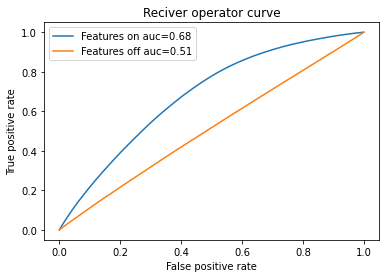

27.620557002226512 minutes elapsed.


In [6]:
#test_out_deep_learning(patientsPerIter = 50, batch_size = 5000, num_epochs = 1, number_of_loops=5, min_rate=100, max_rate=500, doSMOTE=True,doTransformer=False)

test_out_deep_learning(patientsPerIter = 500, batch_size = 5000, num_epochs = 6, number_of_loops=20, min_rate=3, max_rate=15, 
    doSMOTE=False,doTransformer=False,useBASIC=True,HOWDENSE=6,patientsInValidation=1000)
